In [2]:
# https://charlieoneill.medium.com/predicting-the-price-of-bitcoin-with-multivariate-pytorch-lstms-695bc294130

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
import torch.nn as nn
import datetime, pytz

In [11]:
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

# Load dataset

In [34]:
# Descargar de https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1451606400&period2=1656288000&interval=1d&events=history&includeAdjustedClose=true
bitcoin_hist = pd.read_csv("data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv",
                 index_col = 'Timestamp',
                 parse_dates=[0],
                 date_parser=dateparse)
bitcoin_hist.rename(columns={'Volume_(BTC)':'Volume_BTC','Volume_(Currency)':'Volume_USD'}, inplace=True)
bitcoin_hist = bitcoin_hist[-10000:]

In [35]:
df=bitcoin_hist[['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD',
       'Weighted_Price']].interpolate(method='polynomial', order=3)

In [54]:
df.head()

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted_Price
Timestamp,,,,,,,
2021-03-23 22:21:00+00:00,54051.97,54056.30,54032.41,54056.30,0.859630,46467.128609,54054.801030
2021-03-23 22:22:00+00:00,54071.97,54096.66,54059.87,54079.49,0.083730,4528.006377,54078.539371
2021-03-23 22:23:00+00:00,54066.44,54080.41,54065.22,54065.22,0.748505,40476.962325,54077.052898
2021-03-23 22:24:00+00:00,54076.26,54108.46,54076.26,54083.60,1.036144,56031.169707,54076.626811
2021-03-23 22:25:00+00:00,54097.22,54165.92,54097.22,54152.37,0.326656,17681.151855,54127.679537


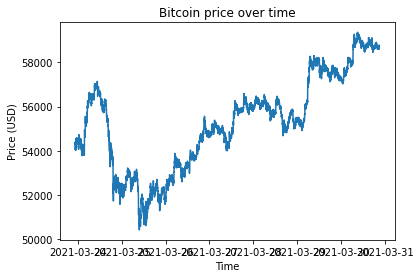

In [36]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

In [37]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((10000, 6), (10000,))

# Normalization of data

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [39]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(9852, 100, 6) (9852, 50)


In [40]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()
y_mm[0]
y_trans[99:149].squeeze(1)

array([0.43970923, 0.43419682, 0.43839192, 0.44521049, 0.45166878,
       0.44675535, 0.44193561, 0.45290467, 0.45337872, 0.45144458,
       0.44467955, 0.44026917, 0.44344589, 0.44344255, 0.43707795,
       0.43348295, 0.4272957 , 0.41772985, 0.41816709, 0.4217766 ,
       0.40873621, 0.41005575, 0.40762525, 0.4189122 , 0.42117873,
       0.42130589, 0.42248935, 0.4305137 , 0.4437069 , 0.45073071,
       0.46215932, 0.46048619, 0.48203614, 0.48047901, 0.47554438,
       0.47555442, 0.47219366, 0.4718278 , 0.47068895, 0.46721553,
       0.47040452, 0.47204307, 0.46934264, 0.46768735, 0.47017586,
       0.4690649 , 0.46210467, 0.46111083, 0.45833008, 0.4557925 ])

In [44]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)
X_train = X_ss[:-150]
X_test = X_ss[-150:]
y_train = y_mm[:-150]
y_test = y_mm[-150:] 
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (9702, 100, 6) (9702, 50)
Testing Shape: (150, 100, 6) (150, 50)


In [45]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [46]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape: torch.Size([9702, 100, 6]) torch.Size([9702, 50])
Testing Shape: torch.Size([150, 100, 6]) torch.Size([150, 50])


In [47]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]
X.iloc[-149:-145]

,Open,High,Low,Volume_BTC,Volume_USD,Weighted_Price
Timestamp,,,,,,
2021-03-30 18:32:00+00:00,58678.59,58707.45,58678.59,0.179466,10533.264393,58692.102167
2021-03-30 18:33:00+00:00,58681.27,58696.78,58664.54,0.386095,22659.454170,58688.733566
2021-03-30 18:34:00+00:00,58696.78,58699.40,58696.78,0.241460,14172.927290,58696.791560
2021-03-30 18:35:00+00:00,58696.79,58709.67,58696.79,0.187330,10997.257070,58705.263814


In [48]:
y_check[-1]
df.Close.values[-50:]

array([58706.24      , 58712.46      , 58704.96      , 58733.62      ,
       58695.71      , 58636.47      , 58622.13      , 58619.3       ,
       58625.31      , 58631.65      , 58656.9       , 58617.21      ,
       58631.35      , 58657.36777453, 58673.85      , 58692.46      ,
       58730.96      , 58721.65      , 58748.45      , 58744.88      ,
       58736.03      , 58755.94      , 58704.68      , 58728.74      ,
       58669.75      , 58628.24      , 58642.47      , 58600.2       ,
       58616.45      , 58616.33      , 58616.33      , 58620.59      ,
       58608.38      , 58600.        , 58600.        , 58666.54      ,
       58702.79      , 58677.7       , 58644.13      , 58689.44      ,
       58699.9       , 58686.91181465, 58698.5       , 58739.95      ,
       58714.31      , 58686.        , 58685.81      , 58723.84      ,
       58760.59      , 58778.18      ])

In [49]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [50]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [55]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [56]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [57]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.38374, test loss: 0.88704
Epoch: 100, train loss: 0.00903, test loss: 0.00482
Epoch: 200, train loss: 0.00378, test loss: 0.00364
Epoch: 300, train loss: 0.00142, test loss: 0.00216
Epoch: 400, train loss: 0.00111, test loss: 0.00103
Epoch: 500, train loss: 0.00098, test loss: 0.00033
Epoch: 600, train loss: 0.00095, test loss: 0.00016
Epoch: 700, train loss: 0.00093, test loss: 0.00013
Epoch: 800, train loss: 0.00091, test loss: 0.00013
Epoch: 900, train loss: 0.00091, test loss: 0.00012


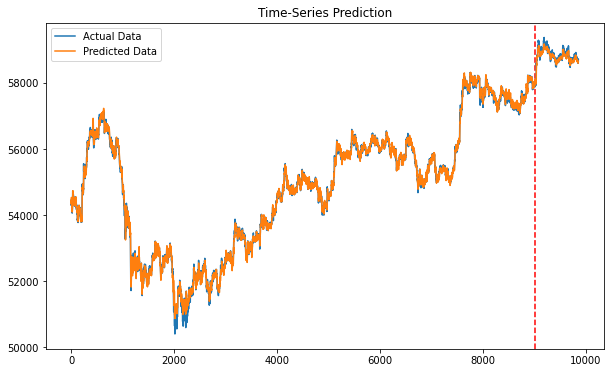

In [58]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show() 

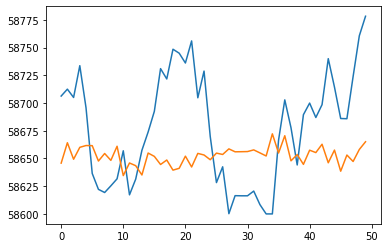

In [59]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.show();

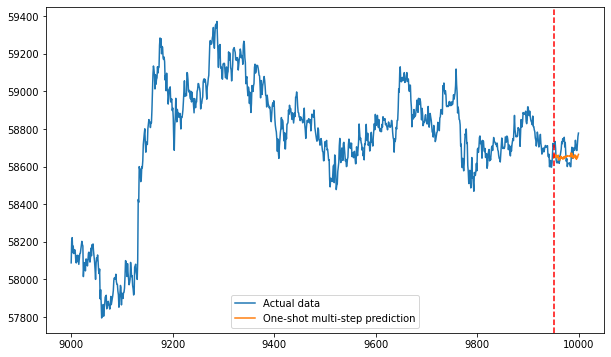

In [60]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(train_test_cutoff, len(y))]
plt.plot(a, y[train_test_cutoff:], label='Actual data');
c = [x for x in range(len(y)-50, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction')
plt.axvline(x=len(y)-50, c='r', linestyle='--')
plt.legend()
plt.show()

In [59]:
train_test_cutoff

2133